## Agglomerative clustering

In [1]:
import multiprocessing as mp
import pandas as pd
import numpy as np

import spacy

from cytoolz import *

from adjustText import adjust_text

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from scipy.cluster import hierarchy
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import *
from sklearn.cluster import *
from sklearn.decomposition import *
from sklearn.manifold import *
from sklearn.neighbors import *

In [3]:
%%time

nlp = spacy.load('en', disable=['tagger', 'parser', 'ner'])

Wall time: 790 ms


In [4]:
%%time 

df = pd.read_csv('https://bit.ly/2usMNpc', compression='gzip')

Wall time: 29.4 s


Only keep reviews for wine variants with more than 500 reviews

In [5]:
%%time

df = df.groupby('wine_variant').filter(lambda x: len(x) > 500).copy()
len(df)

Wall time: 654 ms


## Tokenization

In [6]:
%%time

def tokenize(text):
    return [tok.lower_ for tok in nlp.tokenizer(text)]

Wall time: 0 ns


pandas: <br>
df['tokens'] = df['review_text'].apply(tokenize) <p>
list comprehension: <br>
df['tokens'] = [tokenize(text) for text in df['review_text']] <p>
map function: <br>
df['tokens'] = list(map(tokenize, df['review_text']))

Since each review can be tokenized independently of the others, this task can be easily parallelized on a multi-core CPU:

In [9]:
df['tokens'] = df['review_text'].apply(tokenize)

## Clustering

D, document/term matrix

In [55]:
dtm = make_pipeline(CountVectorizer(analyzer=identity),
                    TfidfTransformer())

In [11]:
D = dtm.fit_transform(df.groupby('wine_variant')['tokens'].apply(concat))
D.shape

(65, 145013)

Agglomerative clustering:

In [12]:
clusters = AgglomerativeClustering(n_clusters=4).fit_predict(D.toarray())

In [13]:
labels = df.groupby('wine_variant')['wine_variant'].apply(pd.unique).index
for cl in set(clusters):
    print(cl,':', ', '.join((labels[clusters==cl])))

0 : Albariño, Champagne Blend, Chardonnay, Chardonnay Blend, Chardonnay, Chenin Blanc, Gewürztraminer, Grüner Veltliner, Melon de Bourgogne, Pinot Blanc, Pinot Grigio, Pinot Gris, Pinot Gris, Riesling, Rosé Blend, Roussanne, Sauvignon Blanc, Sémillon, Sémillon-Sauvignon Blanc Blend, Torrontés, Viognier, White Blend, White Rhone Blend
1 : Aglianico, Barbera, Cabernet Franc, Carignane, Carménère, Corvina Blend, Corvina, Dolcetto, Gamay, Garnacha, Grenache, Grenache, Grenache Blend, Grenache, Malbec, Malbec Blend, Malbec, Mencía, Monastrell, Mourvedre, Montepulciano, Mourvedre, Mourvedre Blend, Mourvedre, Nebbiolo, Nero d'Avola, Pinot Noir, Port Blend, Primitivo, Zinfandel, Red Blend, Red Rhone Blend, Sangiovese, Sangiovese Blend, Sangiovese, SuperTuscan Blend, Syrah, Syrah Blend, Syrah, Tempranillo, Tempranillo Blend, Tempranillo
2 : Cabernet Sauvignon, Cabernet-Shiraz Blend, Cabernet-Syrah Blend, Cabernet-Syrah Blend, Merlot, Merlot Blend, Merlot, Petite Sirah, Red Bordeaux Blend, Shira

Dendrogram

In [14]:
Z = hierarchy.linkage(D.toarray(), 'ward')

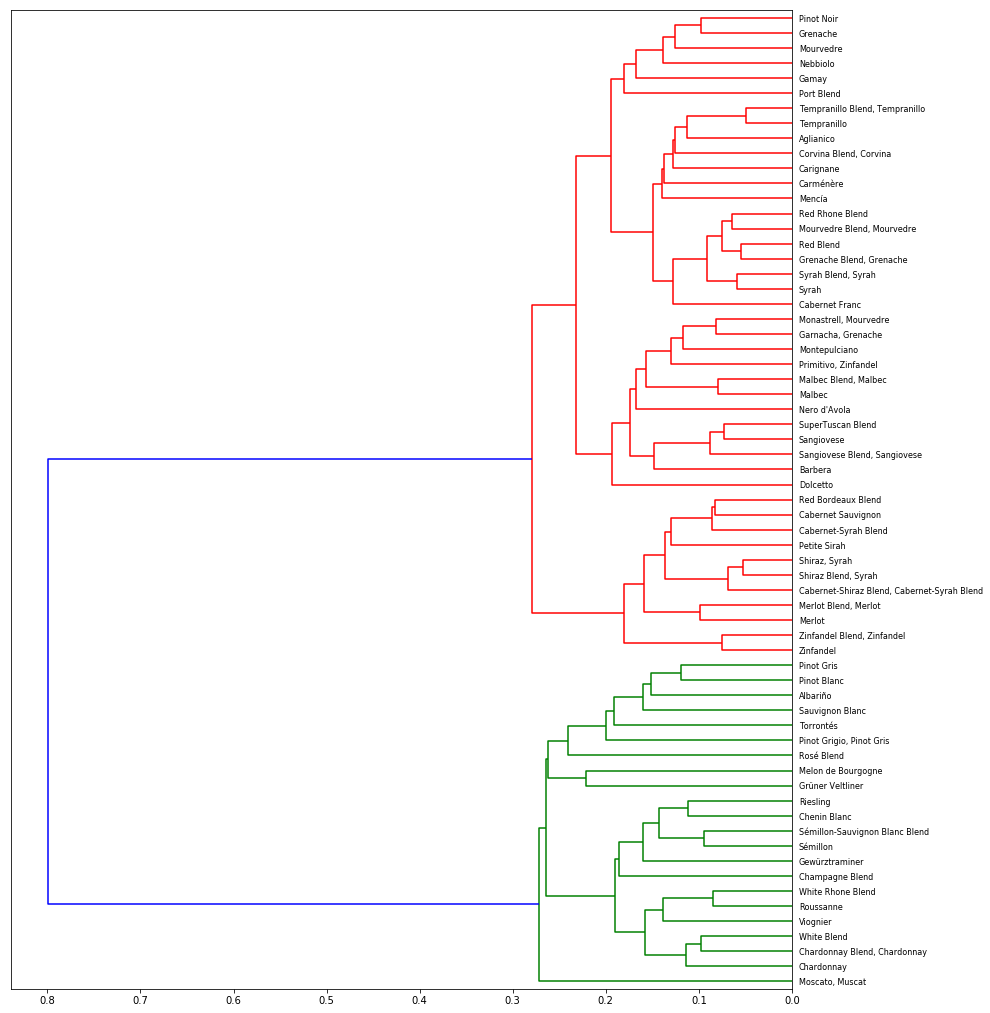

In [15]:
plt.figure(figsize=(14,18))
hierarchy.dendrogram(Z, labels=labels, orientation='left', leaf_font_size=8)
plt.show()


In [16]:
reduce = make_pipeline(TruncatedSVD(100),
                       TSNE(2, perplexity=50, learning_rate=50, early_exaggeration=50))
xy = reduce.fit_transform(D.toarray())

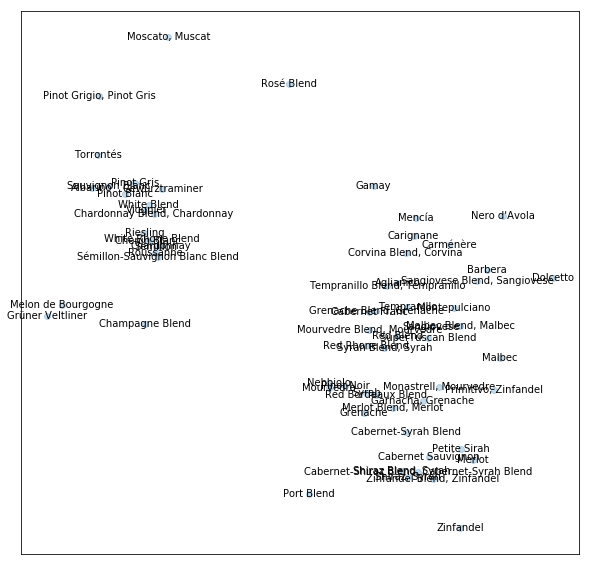

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(xy[:,0], xy[:,1], alpha=0.25)
for x, y, t in zip(xy[:,0], xy[:,1], labels):
    plt.text(x, y, t, ha='center', va='center')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Affinity Propogation

In [18]:
A = AffinityPropagation().fit(D)

In [19]:
clusters = dict(zip(labels, A.labels_))
for c in sorted(set(clusters.values())):
    print(c, ':', ', '.join(k for k,v in clusters.items() if v==c))

0 : Grüner Veltliner
1 : Melon de Bourgogne
2 : Moscato, Muscat
3 : Aglianico, Barbera, Cabernet Franc, Cabernet Sauvignon, Cabernet-Shiraz Blend, Cabernet-Syrah Blend, Cabernet-Syrah Blend, Carignane, Carménère, Corvina Blend, Corvina, Dolcetto, Gamay, Garnacha, Grenache, Grenache, Grenache Blend, Grenache, Malbec, Malbec Blend, Malbec, Mencía, Merlot, Merlot Blend, Merlot, Monastrell, Mourvedre, Montepulciano, Mourvedre, Mourvedre Blend, Mourvedre, Nebbiolo, Nero d'Avola, Petite Sirah, Pinot Noir, Port Blend, Primitivo, Zinfandel, Red Blend, Red Bordeaux Blend, Red Rhone Blend, Sangiovese, Sangiovese Blend, Sangiovese, Shiraz Blend, Syrah, Shiraz, Syrah, SuperTuscan Blend, Syrah, Syrah Blend, Syrah, Tempranillo, Tempranillo Blend, Tempranillo, Zinfandel, Zinfandel Blend, Zinfandel
4 : Rosé Blend
5 : Albariño, Champagne Blend, Chardonnay, Chardonnay Blend, Chardonnay, Chenin Blanc, Gewürztraminer, Pinot Blanc, Pinot Grigio, Pinot Gris, Pinot Gris, Riesling, Roussanne, Sauvignon Blanc,

## NN

In [20]:
neighbors = NearestNeighbors(metric='cosine').fit(D)

In [21]:
V = list(labels)

In [22]:
V.index('Merlot')

25

In [23]:
D[25,:]

<1x145013 sparse matrix of type '<class 'numpy.float64'>'
	with 14374 stored elements in Compressed Sparse Row format>

In [49]:
D.shape

(65, 145013)

In [24]:
neighbors.kneighbors(D[25,:])

(array([[0.        , 0.00482667, 0.00577685, 0.00645708, 0.00657942]]),
 array([[25, 26,  4, 41, 52]], dtype=int64))

In [54]:
neighbors.kneighbors(D[V.index('SuperTuscan Blend')])

(array([[0.        , 0.00258067, 0.00266409, 0.00357739, 0.00373736]]),
 array([[52, 41, 47, 57, 19]], dtype=int64))

In [25]:
def get_neighbors(wine, k=10):
    _, terms = neighbors.kneighbors(D[V.index(wine)], n_neighbors=k)
    return [V[t] for t in terms[0]]

In [26]:
get_neighbors('Merlot')

['Merlot',
 'Merlot Blend, Merlot',
 'Cabernet Sauvignon',
 'Red Blend',
 'SuperTuscan Blend',
 'Red Bordeaux Blend',
 'Garnacha, Grenache',
 'Cabernet-Shiraz Blend, Cabernet-Syrah Blend',
 'Cabernet-Syrah Blend',
 'Monastrell, Mourvedre']

In [27]:
get_neighbors('Pinot Noir')

['Pinot Noir',
 'Grenache',
 'Red Rhone Blend',
 'Sangiovese',
 'Grenache Blend, Grenache',
 'Red Blend',
 'Red Bordeaux Blend',
 'Garnacha, Grenache',
 'Mourvedre Blend, Mourvedre',
 'Nebbiolo']

In [68]:
df.loc[4]

review_points                                                     88
review_text        Muted note, juicy red fruit on the palate. Med...
review_time                                               2009-10-27
review_userName                                               dubdub
wine_name              2006 Domaine Jean Féry & fils Morey St. Denis
wine_variant                                              Pinot Noir
wine_year                                                       2006
lang                                                              en
tokens             [muted, note, ,, juicy, red, fruit, on, the, p...
Name: 4, dtype: object

In [69]:
type(D)

scipy.sparse.csr.csr_matrix

In [79]:
print(D[t] for t in neighbors.kneighbors(D[13])[1])

<generator object <genexpr> at 0x000001E025672408>
